# Docking to EP4 - chembl ligs.

The aim of this notebook is to dock and score all EP4 ligands retrieved from Chembl to see if we can get an idea of the likely binding modes of different scaffolds.

In [ ]:
import os
from IPython import display
from tqdm import tqdm
import warnings
import subprocess
import logging

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdDepictor

# custom drawing options for rdkit molecules:
opts = Draw.MolDrawOptions()
# lighter blue for nitrogen
opts.updateAtomPalette({7: (0.4, 0.4, 1)})
opts.useBWAtomPalette()
# transparent background
opts.clearBackground = True
rdDepictor.SetPreferCoordGen(True)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

import pathlib
from pathlib import Path

from openbabel import pybel
from opencadd.structure.core import Structure
from utils.docking_utils import pdb_to_pdbqt, smiles_to_pdbqt, run_smina, run_gnina, run_smina_autobox, run_gnina_autobox

Protein and data variables.

In [2]:
target = 'ep4'
protein_structure = '5yhl'
ligand_id = '8VL'

In [3]:
# define paths
HERE = Path(pathlib.Path.cwd())
DATA = HERE / f"data_{protein_structure}"
DATA.mkdir(parents=True, exist_ok=True)

In [4]:
fpocket_output = f'{DATA}/{protein_structure}_fpocket.csv'
chembl_input = f'{DATA}/{protein_structure}_chembl.csv'

### Use fpocket to assess druggability and choose binding sites

### fpocket calculation

Run fpocket

In [5]:
! fpocket -f {DATA}/{protein_structure}.pdb -d > {fpocket_output}
! fpocket -f {DATA}/{protein_structure}.pdb

***** POCKET HUNTING BEGINS ***** 
mkdir: cannot create directory ‘/home/corey/Documents/comp_chem/docking/2025-08_docking_chembl_ligs/data_5yhl/5yhl_out/pockets’: File exists
***** POCKET HUNTING ENDS ***** 


Read fpocket output.

In [6]:
df = pd.read_csv(
    fpocket_output,
    sep=' '
    )

In [7]:
df.sort_values(by=['drug_score'], ascending=False)

,cav_id,drug_score,volume,nb_asph,inter_chain,apol_asph_proportion,mean_asph_radius,as_density,mean_asph_solv_acc,mean_loc_hyd_dens,...,val,trp,tyr,chain_1_type,chain_2_type,num_res_chain_1,num_res_chain_2,lig_het_tag,name_chain_1,name_chain_2
0,1,0.9867,1517.5691,210,1,0.6048,3.9005,8.7311,0.4352,56.6772,...,2,2,4,0,0,383,222,8VL,A,H
11,12,0.1909,1444.0593,126,1,0.2937,3.9853,11.5237,0.5126,22.2703,...,1,0,3,0,0,222,213,NaN,H,L
6,7,0.0538,413.7129,32,0,0.8438,3.8855,4.7890,0.6157,20.0741,...,1,0,1,0,0,383,383,NaN,A,A
22,23,0.0301,374.2936,25,0,1.0000,3.9594,2.8653,0.6449,23.9200,...,0,2,1,0,0,383,383,NaN,A,A
17,18,0.0191,267.8176,21,0,0.9524,3.8317,3.6246,0.6964,17.5000,...,0,0,5,0,0,383,383,NaN,A,A
2,3,0.0143,955.5747,128,1,0.2344,3.8524,7.3009,0.4577,17.8667,...,2,3,0,0,0,383,222,NaN,A,H
26,27,0.0091,864.5427,64,1,0.2344,4.0310,7.9469,0.5721,7.4667,...,0,3,3,0,0,222,213,NaN,H,L
1,2,0.0073,134.0293,30,0,0.7000,3.6327,2.4265,0.4449,20.0000,...,0,1,2,0,0,383,383,NaN,A,A
3,4,0.0064,360.9208,31,0,0.6129,3.9163,4.6960,0.6708,15.0526,...,0,0,0,0,0,383,383,NaN,A,A
15,16,0.0046,244.9507,23,0,0.6522,4.0651,2.8871,0.6370,14.0000,...,0,1,1,0,0,383,383,NaN,A,A


### Docking - EP4 Chembl ligands.

In [8]:
warnings.filterwarnings("ignore")
ob_log_handler = pybel.ob.OBMessageHandler()
pybel.ob.obErrorLog.SetOutputLevel(0)

Import locally stored PDB file.

In [9]:
pdb_id = f'{DATA}/{protein_structure}.pdb'
structure = Structure.from_string(pdb_id)

if not hasattr(structure.atoms, "elements"):
    structure.add_TopologyAttr("elements", structure.atoms.types)
structure
# NBVAL_CHECK_OUTPUT

<Universe with 5613 atoms>

In [10]:
# convert protein to PDBQT format
pdb_to_pdbqt(f"{DATA}/{protein_structure}_nolig.pdb", f"{DATA}/{protein_structure}_nolig.pdbqt")

Read and compile ligands from SMILES into a df.

In [45]:
lig_df = pd.read_csv(
    f'{DATA}/ep4_chembl.csv',
    sep=';'
    )

Convert ic50 to pic50.

In [46]:
lig_df['pic50'] = -np.log10(lig_df['Standard Value']*0.0000000001)

In [47]:
# convert the ligands into PDBQT format for docking. 
# If some were missing, run again after generating the ligands to make sure the link to the path is generated.
# TODO: fix function so this repeat step isn't necessary.

def get_or_create_pdbqt(x):
    path = DATA / f"{x['Molecule ChEMBL ID']}.pdbqt"
    if path.exists():
        return path
    else:
        print(f"PDBQT for {x['Molecule ChEMBL ID']} does not exist. Generating...")
        return smiles_to_pdbqt(x.Smiles, path)

lig_df['lig_pdbqt'] = lig_df.apply(get_or_create_pdbqt, axis=1)

What do all of our ligands look like?

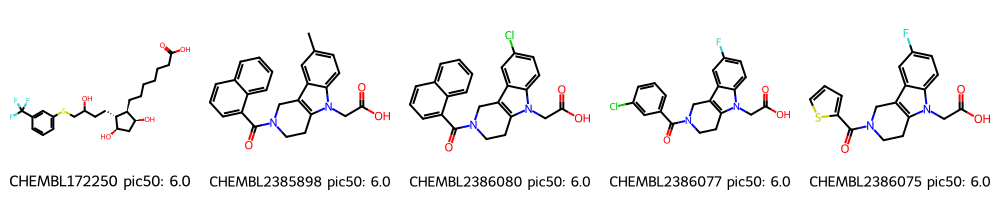

In [48]:
Draw.MolsToImage(
    mols=[Chem.MolFromSmiles(s) for s in list(lig_df.head().Smiles)],
    legends=[
        (" ".join([i, 'pic50:', str(j)])) for i, j, in zip(lig_df['Molecule ChEMBL ID'], lig_df.pic50.round(1))
        ],
    molsPerRow=5,
    maxMols=10,
)

In this case, we dock to the main crystal ligand, so we need to coordinates of it to build the docking box.

In [49]:
ligand = structure.select_atoms(f"resname {ligand_id}")
pocket_center = (ligand.positions.max(axis=0) + ligand.positions.min(axis=0)) / 2
pocket_size = ligand.positions.max(axis=0) - ligand.positions.min(axis=0) + 5
print(pocket_center, pocket_size)

[-44.9505    -42.9355     -1.2995001] [13.567001 13.347    13.253   ]


Run Gnina!

In [50]:
def extract_score_from_sdf(sdf_path):
    """Extract docking score from SDF file using RDKit."""
    try:
        suppl = Chem.SDMolSupplier(sdf_path)
        for mol in suppl:
            if mol is None:
                continue
            # Adjust property name depending on what gnina outputs, e.g., 'minimizedAffinity' or 'docking_score'
            for prop in ['minimizedAffinity', 'CNNscore', 'CNNaffinity']:
                if mol.HasProp(prop):
                    return mol.GetProp(prop)
    except Exception as e:
        logging.warning(f"Failed to read score from {sdf_path}: {e}")
    return None

In [51]:
affinity_list = []

for i, row in lig_df.iterrows():
    try:
        lig_id = row['Molecule ChEMBL ID']
        output_file = f"{DATA}/{protein_structure}_{lig_id}_xtal_pocket_docked.sdf"
        
        if os.path.exists(output_file):
            print(f"Skipping docking for {lig_id} — already docked.")
            docking_score = extract_score_from_sdf(output_file)
            affinity_list.append([lig_id, docking_score])
            continue
        
        print(f"Docking: {lig_id}")
        output_text = run_gnina(f"{DATA}/{lig_id}.pdbqt", # ligs
                                f"{DATA}/{protein_structure}_nolig.pdbqt", # prot
                                output_file, #output ligs
                                pocket_center, pocket_size) # box dimensions from xtal ligand
        print(output_text)
        match = re.search(r"intramol.*\n(?:[^\n]*\n){2}([^\n]*)", output_text) # as Gnina is not deterministic, match the output where the data is in the output
        if match:
            next_line = match.group(1).strip().split()
            if len(next_line) >= 2:
                docking_score = next_line[1]
            else:
                docking_score = None
        else:
            docking_score = None
        # docking_score = output_text.splitlines()[29].split(" ")[7] # retrieve docking score from Smina output
        affinity_list.append([lig_id, docking_score])
    except subprocess.CalledProcessError as e:
        logging.warning(f"Docking failed for {lig_id} with return code {e.returncode}")
        logging.warning(f"stderr: {e.stderr}")
        continue  

    except FileNotFoundError:
        logging.error("Gnina not found. Check if it's in your PATH.")
        break  

[12:08:30] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:08:30] ERROR: Could not sanitize molecule ending on line 77
[12:08:30] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:08:30] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:08:30] ERROR: Could not sanitize molecule ending on line 80
[12:08:30] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:08:30] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:08:30] ERROR: Could not sanitize molecule ending on line 80
[12:08:30] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:08:30] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:08:30] ERROR: Could not sanitize molecule ending on line 80
[12:08:30] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:08:30] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:08:30] ERROR: Could not sanitize molecule ending on lin

Skipping docking for CHEMBL172250 — already docked.
Skipping docking for CHEMBL2385898 — already docked.
Skipping docking for CHEMBL2386080 — already docked.
Skipping docking for CHEMBL2386077 — already docked.
Skipping docking for CHEMBL2386075 — already docked.
Skipping docking for CHEMBL2385906 — already docked.
Skipping docking for CHEMBL400404 — already docked.
Skipping docking for CHEMBL1669006 — already docked.
Skipping docking for CHEMBL1669002 — already docked.
Skipping docking for CHEMBL1669017 — already docked.
Skipping docking for CHEMBL1669008 — already docked.
Skipping docking for CHEMBL1669025 — already docked.
Skipping docking for CHEMBL1669026 — already docked.
Skipping docking for CHEMBL1669013 — already docked.
Skipping docking for CHEMBL1085040 — already docked.
Skipping docking for CHEMBL1084009 — already docked.
Skipping docking for CHEMBL4074035 — already docked.
Skipping docking for CHEMBL3600786 — already docked.
Skipping docking for CHEMBL1084553 — already doc

[12:08:30] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:08:30] ERROR: Could not sanitize molecule ending on line 66
[12:08:30] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted


How do experiment and docking results compare?

In [52]:
affinity_list_df = pd.DataFrame(affinity_list, columns=['Molecule ChEMBL ID', 'docking_score'])
print(affinity_list_df)

    Molecule ChEMBL ID docking_score
0         CHEMBL172250   -8.86162281
1        CHEMBL2385898    5.60151768
2        CHEMBL2386080    -1.5777998
3        CHEMBL2386077   -7.88716364
4        CHEMBL2386075   -4.97349882
..                 ...           ...
592      CHEMBL5204798   -6.41643667
593      CHEMBL5175990   -4.78884459
594      CHEMBL5181722   -8.98128033
595      CHEMBL5195058   -7.39972258
596      CHEMBL5184401   -7.91710615

[597 rows x 2 columns]


In [53]:
# Add docking scores to ligand data frame
lig_df_merged = pd.merge(lig_df, affinity_list_df, on='Molecule ChEMBL ID')
lig_df_merged

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,pic50,lig_pdbqt,docking_score
0,CHEMBL172250,NaN,NaN,478.57,0,4.72,16b,O=C(O)CCCCCC[C@@H]1[C@@H](CCC(O)CSc2cccc(C(F)(...,IC50,'>',...,Scientific Literature,J Med Chem,2000,CHEMBL3308072,NaN,NaN,NaN,6.000000,/home/corey/Documents/comp_chem/docking/2025-0...,-8.86162281
1,CHEMBL2385898,NaN,NaN,398.46,0,4.39,29,Cc1ccc2c(c1)c1c(n2CC(=O)O)CCN(C(=O)c2cccc3cccc...,IC50,'>',...,Scientific Literature,J Med Chem,2013,CHEMBL3307715,NaN,NaN,NaN,6.000000,/home/corey/Documents/comp_chem/docking/2025-0...,5.60151768
2,CHEMBL2385898,NaN,NaN,398.46,0,4.39,29,Cc1ccc2c(c1)c1c(n2CC(=O)O)CCN(C(=O)c2cccc3cccc...,IC50,'>',...,Scientific Literature,J Med Chem,2013,CHEMBL3307715,NaN,NaN,NaN,6.000000,/home/corey/Documents/comp_chem/docking/2025-0...,5.60151768
3,CHEMBL2386080,NaN,NaN,418.88,0,4.73,27,O=C(O)Cn1c2c(c3cc(Cl)ccc31)CN(C(=O)c1cccc3cccc...,IC50,'>',...,Scientific Literature,J Med Chem,2013,CHEMBL3307715,NaN,NaN,NaN,6.000000,/home/corey/Documents/comp_chem/docking/2025-0...,-1.5777998
4,CHEMBL2386080,NaN,NaN,418.88,0,4.73,27,O=C(O)Cn1c2c(c3cc(Cl)ccc31)CN(C(=O)c1cccc3cccc...,IC50,'>',...,Scientific Literature,J Med Chem,2013,CHEMBL3307715,NaN,NaN,NaN,6.000000,/home/corey/Documents/comp_chem/docking/2025-0...,-1.5777998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,CHEMBL5204798,NaN,NaN,439.51,0,4.74,48,C[C@@H](NC(=O)c1c(Cc2ccc(F)cc2)sc2c1CCOC2)c1cc...,IC50,'=',...,Scientific Literature,J Med Chem,2022,NaN,TIME = 0.25 hr,ANTAGONIST,NaN,7.104522,/home/corey/Documents/comp_chem/docking/2025-0...,-6.41643667
1123,CHEMBL5175990,NaN,NaN,449.50,0,4.55,29,C[C@H](NC(=O)c1c(C#Cc2ccc(F)cc2)sc2c1CCOC2)c1c...,IC50,'=',...,Scientific Literature,J Med Chem,2022,NaN,TIME = 0.25 hr,ANTAGONIST,NaN,8.801343,/home/corey/Documents/comp_chem/docking/2025-0...,-4.78884459
1124,CHEMBL5181722,NaN,NaN,437.54,1,5.35,17,C[C@H](NC(=O)c1c(CCc2ccc(F)cc2)sc2c1CCC2)c1ccc...,IC50,'=',...,Scientific Literature,J Med Chem,2022,NaN,TIME = 0.25 hr,ANTAGONIST,NaN,8.987163,/home/corey/Documents/comp_chem/docking/2025-0...,-8.98128033
1125,CHEMBL5195058,NaN,NaN,453.54,0,4.93,22,C[C@H](NC(=O)c1c(CCc2ccc(F)cc2)sc2c1CCOC2)c1cc...,IC50,'=',...,Scientific Literature,J Med Chem,2022,NaN,TIME = 0.25 hr,ANTAGONIST,NaN,8.718967,/home/corey/Documents/comp_chem/docking/2025-0...,-7.39972258


In [54]:
# recast as floats for lmplot
lig_df_merged['pic50'] = lig_df_merged['pic50'].astype(float)
lig_df_merged['docking_score'] = lig_df_merged['docking_score'].astype(float)

Exclude ligands with unfavourable docking scores.

In [57]:
lig_df_merged = lig_df_merged[lig_df_merged['docking_score'] < 0]

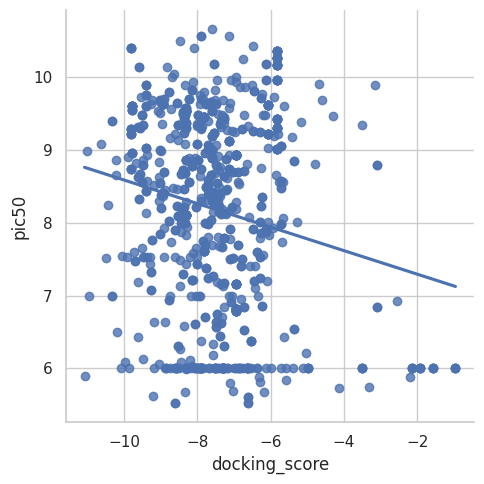

In [58]:
x = 'docking_score'
y = 'pic50'    

sns.set_theme(style='whitegrid')

g2 = sns.lmplot(data=lig_df_merged, x=x, y=y, 
                ci=True,
            )            